# Collation

(Note: Error in package install via pip; one needs to install `python-Levenshtein` **before** installing Collatex. Detailed instructions go here: http://collatex.obdurodon.org/installation.xhtml)

In [1]:
from collatex import *

collation = Collation()
collation.add_plain_witness("UK", "Harry Potter and the Philosopher's Stone")
collation.add_plain_witness("US", "Harry Potter and the Sorcerer's Stone")

alignment_table = collate(collation)

print(alignment_table)

+----+----------------------+-------------+----------+
| UK | Harry Potter and the | Philosopher | 's Stone |
| US | Harry Potter and the | Sorcerer    | 's Stone |
+----+----------------------+-------------+----------+


In [2]:
for i in alignment_table.columns:
    print(i.tokens_per_witness)
    for idx, tokens in i.tokens_per_witness.items():
        print(tokens)
    print('===')

{'UK': [Harry, Potter, and, the], 'US': [Harry, Potter, and, the]}
[Harry, Potter, and, the]
[Harry, Potter, and, the]
===
{'UK': [Philosopher], 'US': [Sorcerer]}
[Philosopher]
[Sorcerer]
===
{'UK': [', s, Stone], 'US': [', s, Stone]}
[', s, Stone]
[', s, Stone]
===


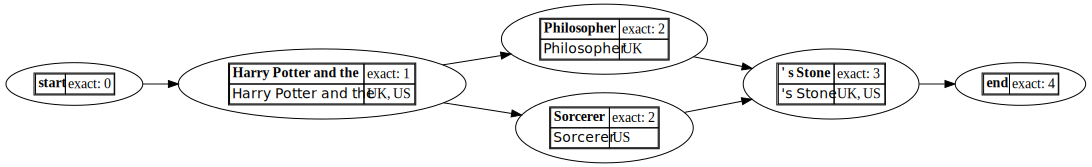

In [3]:
collate(collation,output="svg")

In [139]:
from lxml import etree
from collections import OrderedDict

def load_potter(fn):
    series = etree.parse(fn)
    HP = OrderedDict()
    for book in series.iterfind('.//book'):
        book_title = book.attrib['title']
        #print(book_title)
        HP[book_title] = OrderedDict()
        
        for chapter in book.iterfind('.//chapter'):
            chapter_title = chapter.attrib['title']
            #print('   ', chapter_title)
            HP[book_title][chapter_title] = []
            
            for paragraph in chapter.iterfind('.//p'):
                text = ''.join([x for x in paragraph.itertext()])
                HP[book_title][chapter_title].append(text)
    return HP

uk = load_potter('../preprocessing/simple_potter_uk.xml')
us = load_potter('../preprocessing/simple_potter_us.xml')

In [140]:
book = "Harry Potter and the Prisoner of Azkaban"
uk_chap = ' '.join(uk[book]['Owl Post'])[:100000]
us_chap = ' '.join(us[book]['OWL POST'])[:100000]

In [141]:
print(uk_chap[:1000])
print(us_chap[:1000])

Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework, but was forced to do it in secret, in the dead of night. And he also happened to be a wizard. It was nearly midnight, and he was lying on his front in bed, the blankets drawn right over his head like a tent, a torch in one hand and a large leather-bound book (A History of Magic, by Bathilda Bagshot) propped open against the pillow. Harry moved the tip of his eagle-feather quill down the page, frowning as he looked for something that would help him write his essay, ‘Witch-Burning in the Fourteenth Century Was Completely Pointless – discuss’. The quill paused at the top of a likely-looking paragraph. Harry pushed his round glasses up his nose, moved his torch closer to the book and read: Harry put his quill between his teeth and reached underneath his pillow for his ink bottle and a roll of parchment. Slowly an

In [95]:
collation = Collation()
collation.add_plain_witness("UK", uk_chap)
collation.add_plain_witness("US", us_chap)
alignment_table = collate(collation, layout='vertical')

#collate(collation,output="svg")
collate(collation, layout='vertical', output='html2')

Catch 'plain' synonyms:

In [110]:
from nltk.corpus import wordnet as wn

def is_synonym(w1, w2):
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    synonym = False
    for synset in wn.synsets(w1):
        for lemma in synset.lemma_names():
            if lemma.lower() == w2.lower():
                synonym = True
    for synset in wn.synsets(w2):
        for lemma in synset.lemma_names():
            if lemma.lower() == w1.lower():
                synonym = True
    return synonym

print(is_synonym('torch', 'flashlight'))
print(is_synonym('torch', 'dog'))
print(is_synonym('cutting', 'clipping'))

True
False
True


Catch 'standard' spelling differences:

In [156]:
uk_to_us_spellings = []
for line in open('uk_vs_us.txt', 'r'):
    if not line.strip().startswith('#'):
        uk_to_us_spellings.append(line.strip().split())

def is_spelling_diff(w1, w2):
    spelling = False
    w1 = w1.strip().lower()
    w2 = w2.strip().lower()
    
    if ''.join(OrderedDict.fromkeys(w1)) == ''.join(OrderedDict.fromkeys(w2)):
        spelling = True
    elif ''.join(w1.split()) == ''.join(w2.split()):
        spelling = True
    else:
        for british, american in uk_to_us_spellings:
            if w1.endswith(british) and w2.endswith(american):
                spelling = True
    
    return spelling

print(is_spelling_diff('towards', 'toward'))
print(is_spelling_diff('colour', 'color'))
print(is_spelling_diff('analyse', 'analyze'))

True
True
True


In [149]:
def score_diffs(uk_chap, us_chap):
    nb_style_diffs = 0
    
    collation = Collation()
    collation.add_plain_witness("UK", uk_chap)
    collation.add_plain_witness("US", us_chap)
    alignment_table = collate(collation, layout='vertical')
    
    uk, us = [row.to_list_of_strings() for row in alignment_table.rows]

    for a, b in zip(uk, us):
        if not (a is None or b is None):
            a = a.strip().lower()
            b = b.strip().lower()
            
            a = ''.join([c for c in a if c.isalpha() or c.isspace()])
            b = ''.join([c for c in b if c.isalpha() or c.isspace()])
            
            if a and b and a != b:
                if is_spelling_diff(a, b):
                    print(a, 'vs', b, '-> SPELLING')
                elif is_synonym(a, b):
                    print(a, 'vs', b, '-> SYNONYM')
                else:
                    nb_style_diffs += 1
                    print(a, 'vs', b, '-> STYLISTIC')
    
    # normalize by the number of characters in the UK chapter
    return nb_style_diffs / len(uk_chap.strip())

In [150]:
print(score_diffs(uk_chap, us_chap))

on to vs onto -> STYLISTIC


UnboundLocalError: local variable 'key_' referenced before assignment

In [158]:
UK_HP = load_potter('../preprocessing/simple_potter_uk.xml')
US_HP = load_potter('../preprocessing/simple_potter_us.xml')

diffs = {}
for uk_book, us_book in zip(UK_HP, US_HP):
    print(uk_book, 'vs', us_book)
    diffs[uk_book] = []
    
    for uk_chap, us_chap in zip(UK_HP[uk_book], US_HP[us_book]):
        uk_chap = ' '.join(UK_HP[uk_book][uk_chap])#[:1000]
        us_chap = ' '.join(US_HP[us_book][us_chap])#[:1000]

        score = score_diffs(uk_chap, us_chap)
        print(score)
        
        diffs[uk_book].append(score)

Harry Potter and the Philosopher's Stone vs Harry Potter and the Sorcerer's Stone
moustache vs mustache -> SPELLING
neighbours vs neighbors -> SPELLING
neighbours vs neighbors -> SPELLING
grey vs gray -> SPELLING
realise vs realize -> SPELLING
towards vs toward -> SPELLING
car park vs parking lot -> STYLISTIC
bakers opposite vs bakery -> STYLISTIC
lot vs bunch -> SYNONYM
dialling vs dialing -> SPELLING
moustache vs mustache -> SPELLING
realised vs realized -> SPELLING
behaviour vs behavior -> SPELLING
learnt vs learned -> STYLISTIC
shan vs won -> STYLISTIC
news reader vs newscaster -> STYLISTIC
  vs     -> SPELLING
lot vs crowd -> STYLISTIC
was vs were -> STYLISTIC
in vs on -> STYLISTIC
in vs on -> STYLISTIC
which vs that -> STYLISTIC
realise vs realize -> SPELLING
realise vs realize -> SPELLING
in vs on -> STYLISTIC
towards vs toward -> SPELLING
rumours vs rumors -> SPELLING
  vs drop  -> STYLISTIC
sherbet lemons  vs lemon drops  -> STYLISTIC
sherbet lemons vs lemon drops -> STYLISTIC

KeyboardInterrupt: 